In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import tensorflow as tf
import sys

import onnx
import onnx_tf
import onnxruntime
import scipy

print("Tensorflow ",tf.__version__)
print("Numpy ", np.__version__)
print("Scipy ", scipy.__version__)
print("Pandas ", pd.__version__)
print("Matplotlib ", matplotlib.__version__)
print("Python ", sys.version)

print("onnx ", onnx.__version__)
print("onnx_tf", onnx_tf.__version__)
print("onnxruntime", onnxruntime.__version__)

tf.keras.utils.set_random_seed(42202242)
rng = np.random.default_rng()

Tensorflow  2.9.1
Numpy  1.22.4
Scipy  1.9.0
Pandas  1.4.3
Matplotlib  3.5.2
Python  3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
onnx  1.12.0
onnx_tf 1.10.0
onnxruntime 1.11.1


In [2]:
sys.path.append("../../experiments/distill_before_verify_acasxu/")
from experiment_lib import AcasXUNetwork, load_vnncomp_2021_acasxu_network, distill_using_only_crossentropy_loss

# Explore ACAS-Xu Distillation

In this notebook, we demonstrate network distillation and verification using acas xu, and create figures such as the decision boundary heatmap.

In [3]:
acas_xu = load_vnncomp_2021_acasxu_network(tau=1, a_prev=1, path="../../data/acasxu")

## Train student network using Data-Free Distillation

In [4]:
## Generate synthetic training dataset using a random distribution.
num_synthetic_points = 2**16

synthetic_inputs = (rng.random((num_synthetic_points,5),dtype="float32")-0.5)
synthetic_outputs = acas_xu.run(synthetic_inputs)


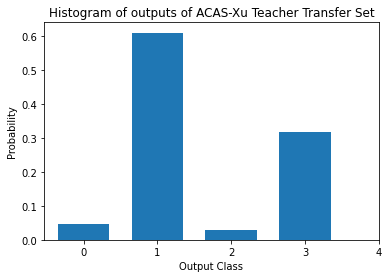

In [5]:
plt.hist(np.argmax(synthetic_outputs, axis=1), bins=[0,1,2,3,4], align="left", rwidth=0.7, density=True)
plt.xticks([0,1,2,3,4])
plt.xlabel("Output Class")
plt.ylabel("Probability")
plt.title("Histogram of outputs of ACAS-Xu Teacher Transfer Set")
plt.show()

In [6]:
student, history = distill_using_only_crossentropy_loss(acas_xu,
    n_synthetic_data_points=2**16,
    synthetic_data_sampling="random_iid",
    hidden_layer_width=50,
    num_hidden_layers=3,
    verbose=2)

Epoch 1/500
64/64 - 1s - loss: 1.1504 - sparse_categorical_accuracy: 0.6077 - val_loss: 0.9813 - val_sparse_categorical_accuracy: 0.6059 - 683ms/epoch - 11ms/step
Epoch 2/500
64/64 - 0s - loss: 0.8801 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.8266 - val_sparse_categorical_accuracy: 0.7398 - 169ms/epoch - 3ms/step
Epoch 3/500
64/64 - 0s - loss: 0.7822 - sparse_categorical_accuracy: 0.7428 - val_loss: 0.7464 - val_sparse_categorical_accuracy: 0.7423 - 161ms/epoch - 3ms/step
Epoch 4/500
64/64 - 0s - loss: 0.7111 - sparse_categorical_accuracy: 0.7486 - val_loss: 0.6790 - val_sparse_categorical_accuracy: 0.7506 - 149ms/epoch - 2ms/step
Epoch 5/500
64/64 - 0s - loss: 0.6549 - sparse_categorical_accuracy: 0.7589 - val_loss: 0.6335 - val_sparse_categorical_accuracy: 0.7663 - 143ms/epoch - 2ms/step
Epoch 6/500
64/64 - 0s - loss: 0.6128 - sparse_categorical_accuracy: 0.7786 - val_loss: 0.5948 - val_sparse_categorical_accuracy: 0.7912 - 164ms/epoch - 3ms/step
Epoch 7/500
64/64 - 0s - lo

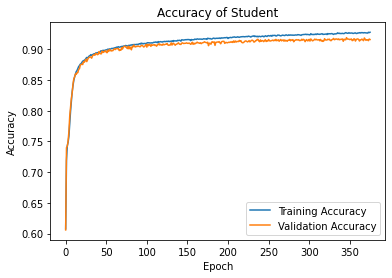

In [7]:
plt.plot(history.history["sparse_categorical_accuracy"], label="Training Accuracy")
plt.plot(history.history["val_sparse_categorical_accuracy"], label="Validation Accuracy")
plt.title("Accuracy of Student")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

7813/7813 [==============================] - 6s 713us/step


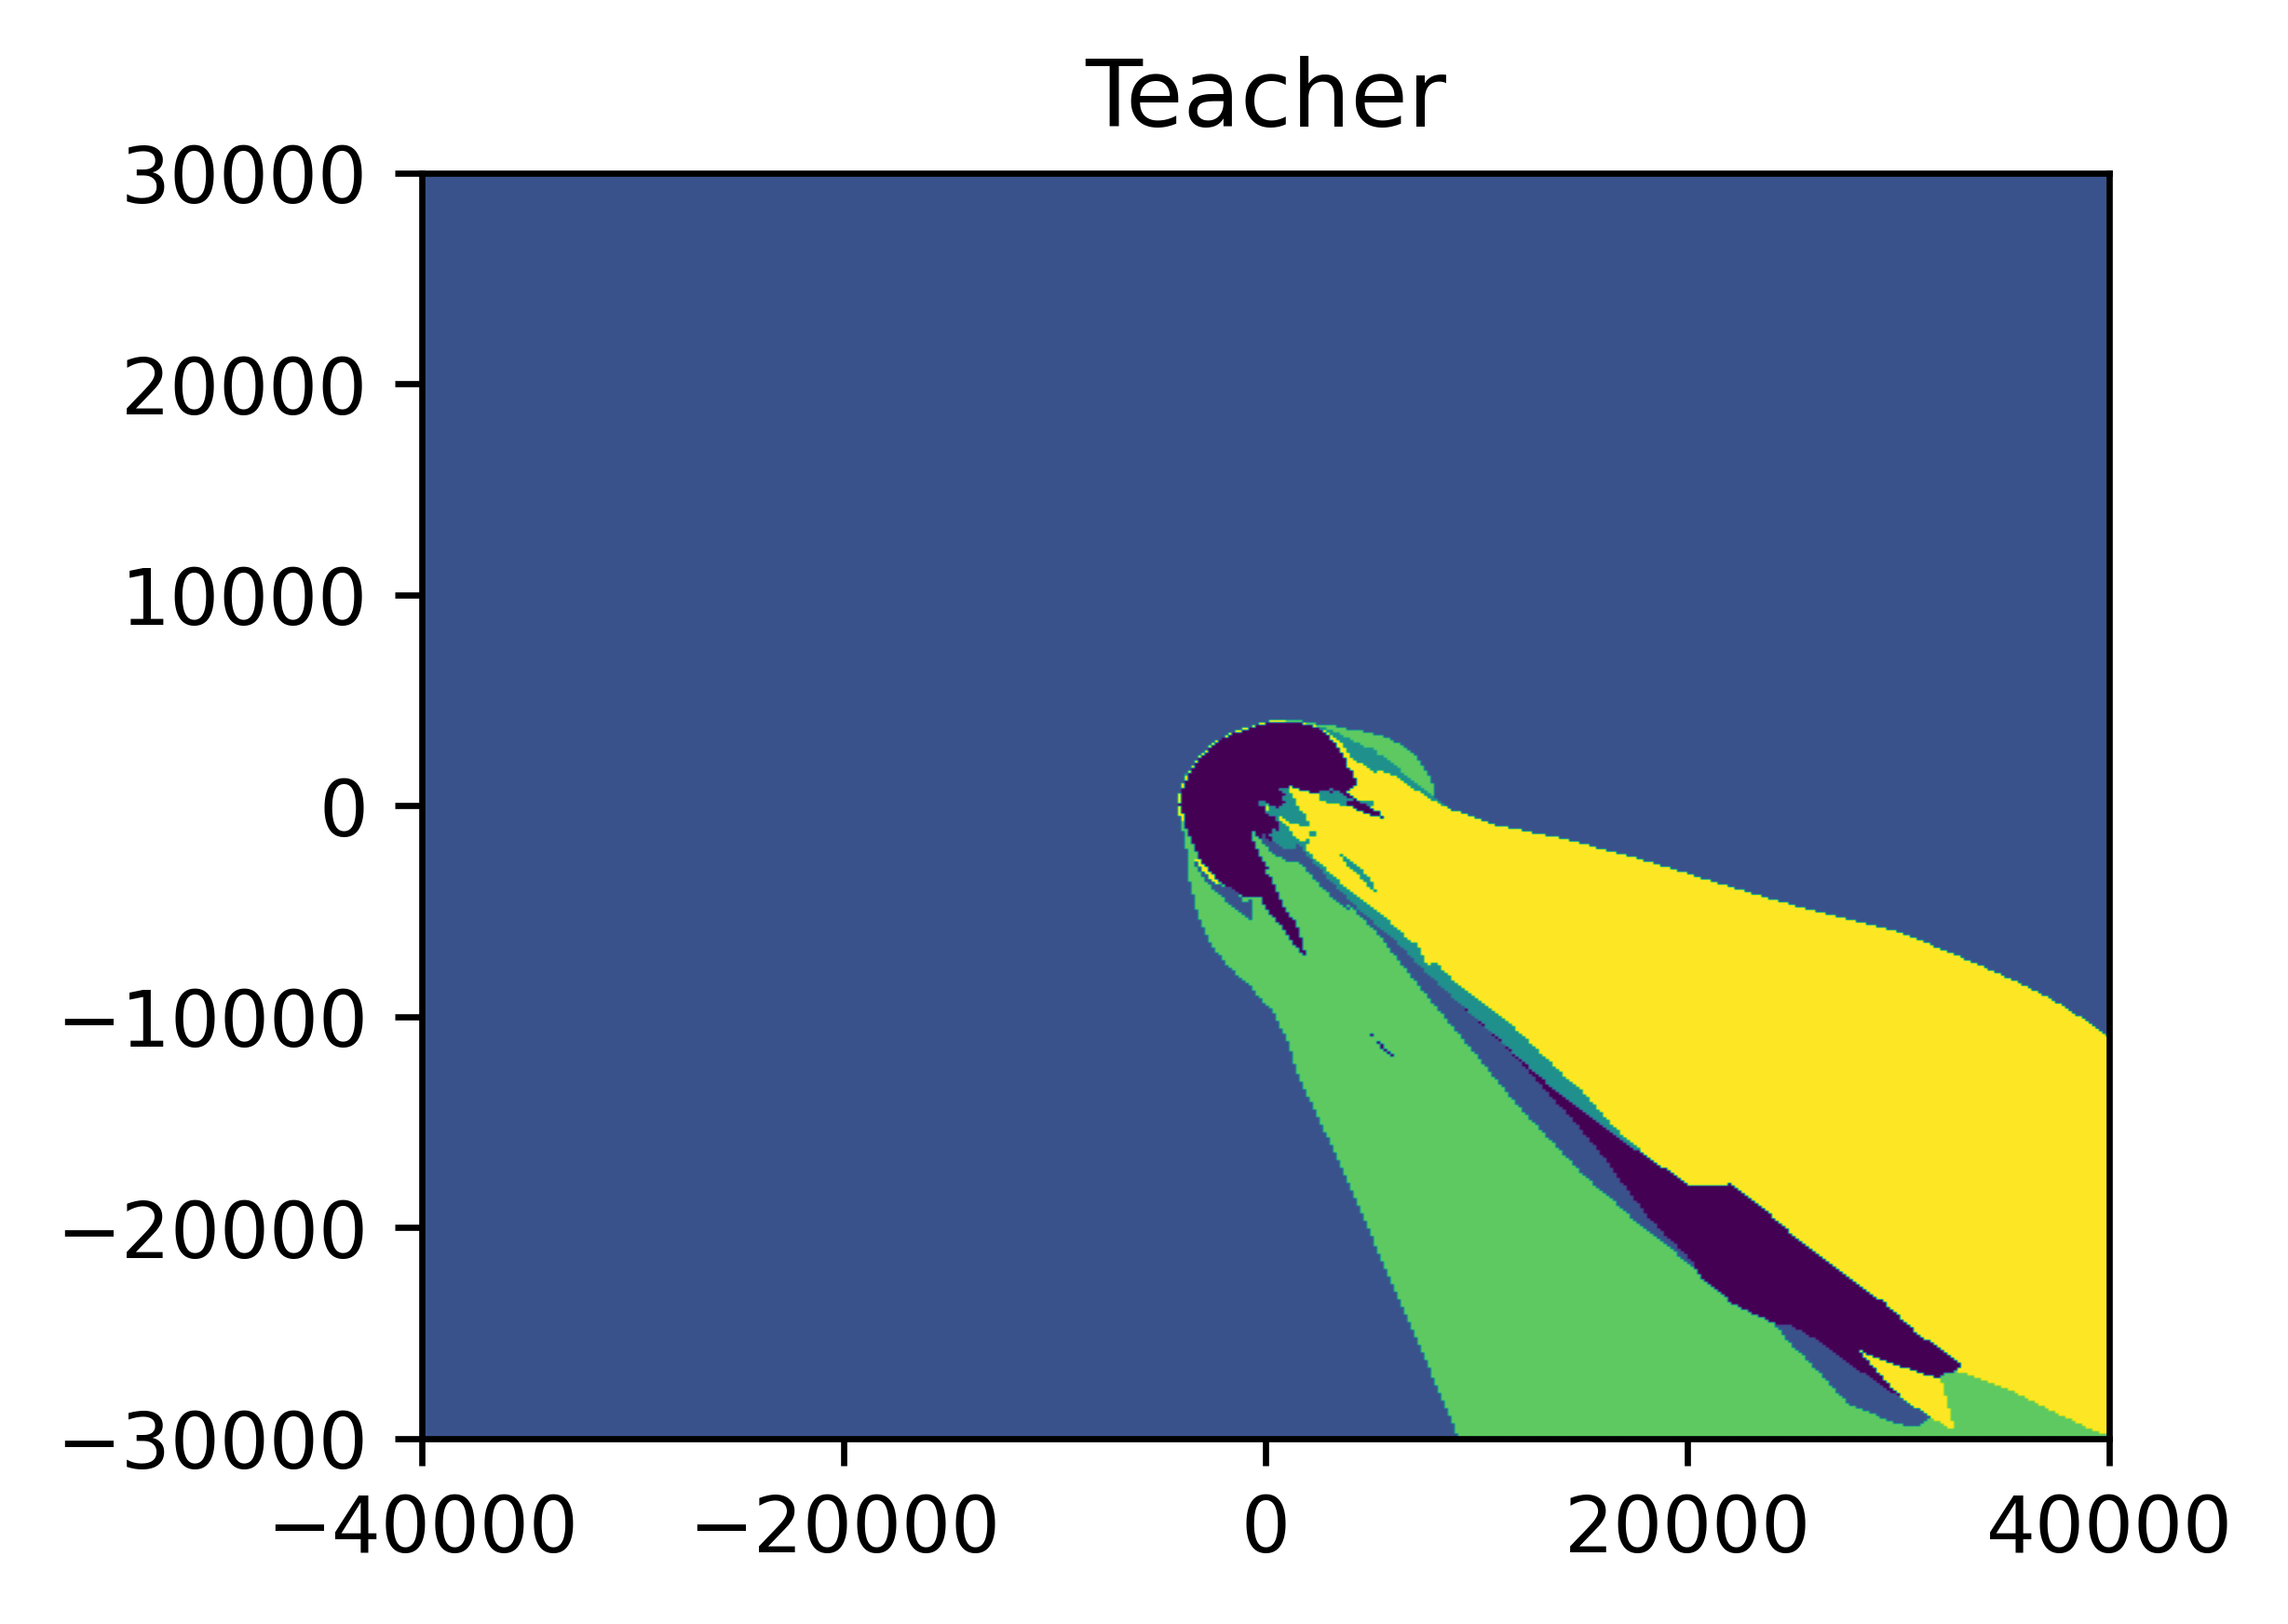

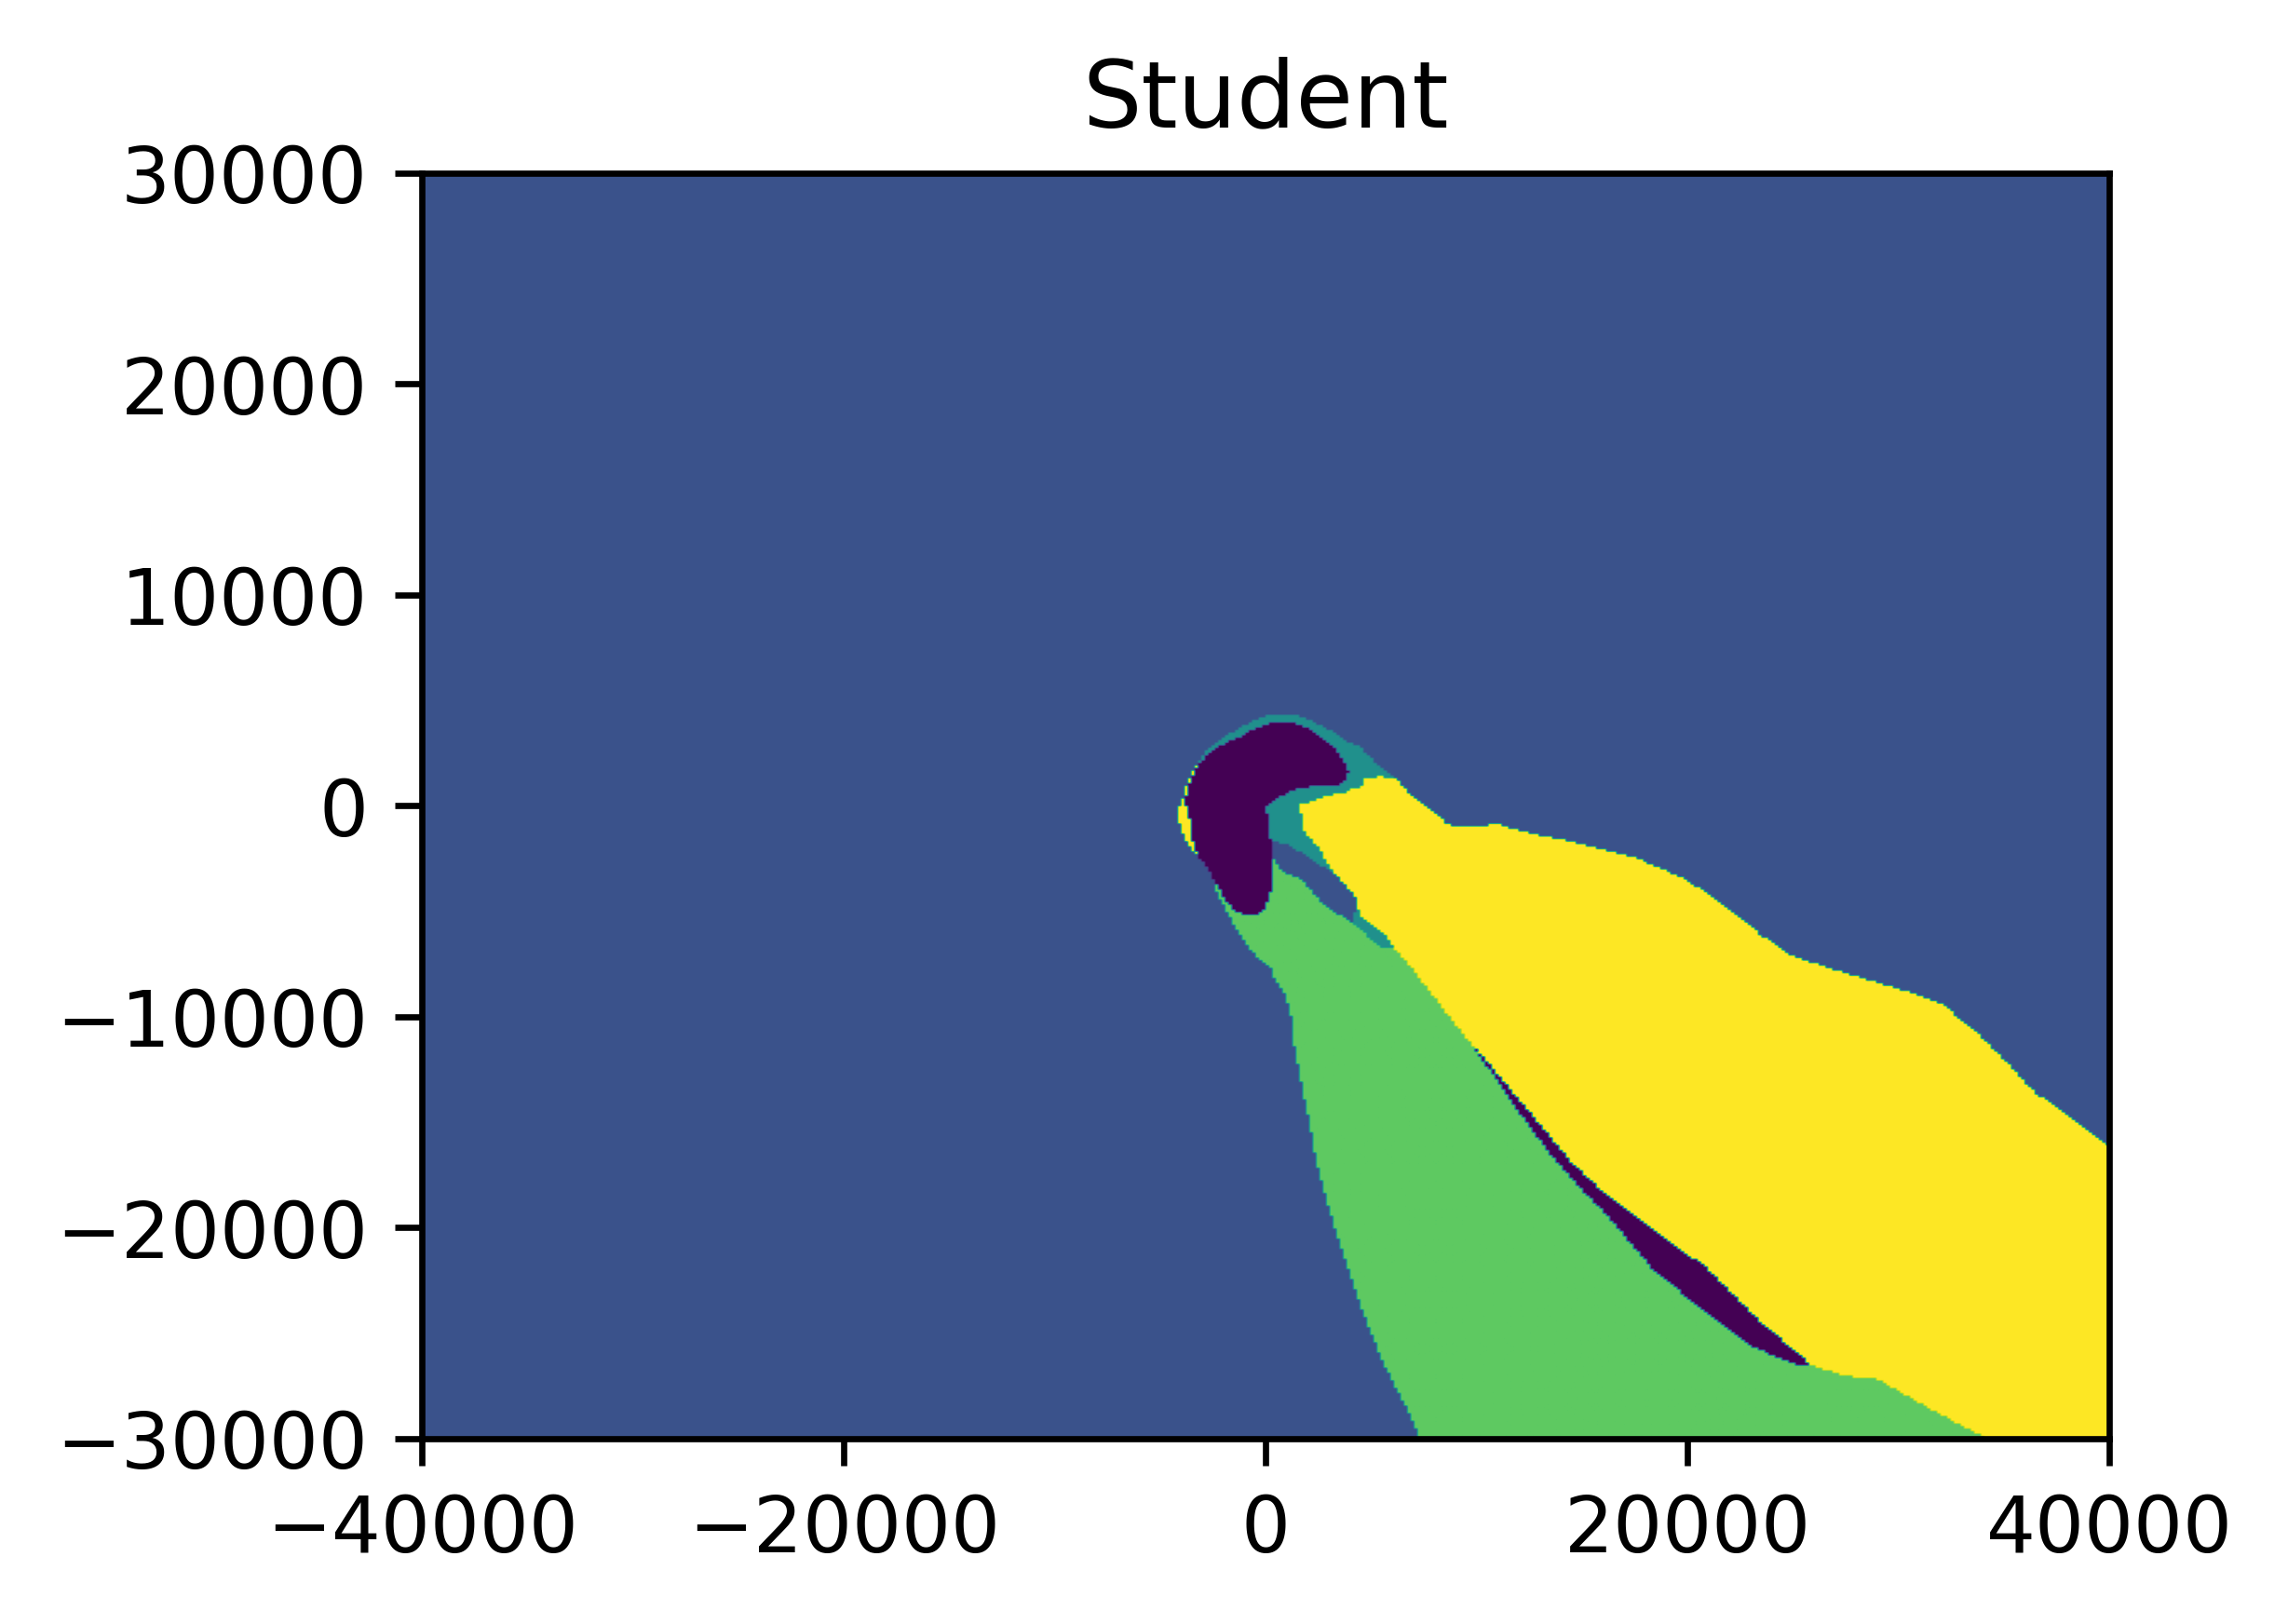

In [8]:
# Input Scaling

nx, ny = (500, 500)

x = np.linspace(-40000,40000, nx)
y = np.linspace(-30000,30000, ny)
xx,yy = np.meshgrid(x,y)

def cart2pol(x, y):
    theta = np.arctan2(y, x)
    rho = np.hypot(x, y)
    return theta, rho

tt,rr = cart2pol(xx,yy)

inputs_here = [rr.flatten(), # Distance between ownship and intruder
               tt.flatten(), # Angle between ownship and intruder
               -np.pi/2, # Angle of intruder relative to angle of ownship
               600, # Velocity of ownship
               600] # Velocity of intruder

## From VNNCOMP repository
means_for_scaling = [19791.091, 0.0, 0.0, 650.0, 600.0, 7.5188840201005975]
range_for_scaling = [60261.0, 6.28318530718, 6.28318530718, 1100.0, 1200.0]

coords = np.zeros(shape=(nx*ny,5),dtype="float32")
for i in range(5):
    coords[:,i] = (inputs_here[i] - means_for_scaling[i])/range_for_scaling[i]


teacher_image = acas_xu.run(coords).argmax(axis=1)
student_image = student.predict(coords).argmax(axis=1)


extent = -40000, 40000, -30000, 30000
plt.figure(figsize=(4,3),dpi=600)
plt.imshow(teacher_image.reshape(nx,ny), extent=extent)
plt.title("Teacher")
plt.show()

plt.figure(figsize=(4,3),dpi=600)
plt.imshow(student_image.reshape(nx,ny), extent=extent)
plt.title("Student")
plt.show()

## Verify student and teacher networks

Use the 10 properties provided in VNNComp to check if the student network satisfies the safety properties. Produce the following:

- Timing information
- Counterexamples
- Failiure modes of nnenum
- List of verified networks

## NNenum

In [9]:
tf.saved_model.save(student, "../../output_data/acasxu_distillation/student_model")

INFO:tensorflow:Assets written to: ../../output_data/acasxu_distillation/student_model/assets


In [10]:
!python -m tf2onnx.convert --saved-model ../../output_data/acasxu_distillation/student_model --output ../../output_data/acasxu_distillation/student_model.onnx --opset 11

/Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-11-06 20:09:02,064 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-11-06 20:09:02,294 - INFO - Signatures found in model: [serving_default].
2022-11-06 20:09:02,294 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-11-06 20:09:02,294 - INFO - Output names: ['dense_3']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-11-06 20:09:02,439 - WARNING - From /Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/site-packages/tf2onnx/tf_loader.py:711: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.comp

In [11]:
!docker run -it -v /Users/jperrsau/cu-src/thesis/src/distill:/distill nnenum_image bash -c "python3 -m nnenum.nnenum /distill/data/acasxu/ACASXU_run2a_1_1_batch_2000.onnx /distill/data/acasxu/prop_1.vnnlib > /distill/output_data/acasxu_distillation/verify_teacher.stdout"

In [12]:
!docker run -it -v /Users/jperrsau/cu-src/thesis/src/distill:/distill nnenum_image bash -c "python3 -m nnenum.nnenum /distill/output_data/acasxu_distillation/student_model.onnx /distill/data/acasxu/prop_1.vnnlib > /distill/output_data/acasxu_distillation/verify_student.stdout"

## All 10 properties with timing

In [13]:
import subprocess
import re

In [14]:
for prop in range(1,10+1):
    print(f"Property {prop}")

    cmd = f"docker run -v /Users/jperrsau/cu-src/thesis/src/distill:/distill nnenum_image python3 -m nnenum.nnenum /distill/output_data/acasxu_distillation/student_model.onnx /distill/data/acasxu/prop_{prop}.vnnlib"
    result = subprocess.getoutput(cmd)
    try:
        runtime_re = re.search("Runtime: (\d+\.\d+)", result).groups(0)[0]
        result_re = re.search("Result: ([a-zA-Z\s]+)", result).groups(0)[0]
        print(f"\tStudent:\tTime={runtime_re}\tOutput={result_re}")
    except Exception as e:
        print("Exception")

    cmd = f"docker run -v /Users/jperrsau/cu-src/thesis/src/distill:/distill nnenum_image python3 -m nnenum.nnenum /distill/data/acasxu/ACASXU_run2a_1_1_batch_2000.onnx /distill/data/acasxu/prop_{prop}.vnnlib"
    result = subprocess.getoutput(cmd)
    try:
        runtime_re = re.search("Runtime: (\d+\.\d+)", result).groups(0)[0]
        result_re = re.search("Result: ([a-zA-Z\s]+)", result).groups(0)[0]
        print(f"\tTeacher:\tTime={runtime_re}\tOutput={result_re}")
    except Exception as e:
        print("Exception")


    

Property 1
	Student:	Time=0.3	Output=network is SAFE
	Teacher:	Time=0.7	Output=network is SAFE
Property 2
	Student:	Time=0.8	Output=network is SAFE
	Teacher:	Time=1.8	Output=network is SAFE
Property 3
Exception
	Teacher:	Time=2.9	Output=network is SAFE
Property 4
	Student:	Time=0.1	Output=network is SAFE
	Teacher:	Time=0.7	Output=network is SAFE
Property 5
	Student:	Time=0.1	Output=network is UNSAFE with confirmed counterexample in result
	Teacher:	Time=4.0	Output=network is SAFE
Property 6
	Student:	Time=0.2	Output=network is UNSAFE with confirmed counterexample in result
	Teacher:	Time=9.5	Output=network is SAFE
Running in parallel with 
Property 7
	Student:	Time=0.1	Output=network is UNSAFE with confirmed counterexample in result
	Teacher:	Time=0.1	Output=network is UNSAFE with confirmed counterexample in result
Property 8
	Student:	Time=0.2	Output=network is UNSAFE with confirmed counterexample in result
	Teacher:	Time=0.2	Output=network is UNSAFE with confirmed counterexample in r